<a href="https://colab.research.google.com/github/Ella77/Korean-Tacotron2-Waveglow/blob/master/SJ_inference_T2%2BWG_on_COLAB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## TTS inference with Tacotron2+ WaveGlow on Google COLAB

by Hyungon Ryu | Sr. Solution Architect at NVIDIA


In this COLAB Jupyter, I'll demonstrate how to generate voice from input text with Tacotron2 + WaveGlow Model.

## DevOps

Check Available GPU. COLAB provide Tesla K80.

In [0]:
!nvidia-smi

Tue Jun 25 06:59:46 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            On   | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P0    26W /  70W |    973MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

### set max clock

In [0]:
%%bash
#check the environemnt 
echo "Check H/W"
lscpu | grep 'CPU(s):            '
lscpu | grep GHz
echo "memory" && free -m | cut -c-49 |  head -n 2 
echo "storage" && df -h |  cut -c-60 | head -n 2
df -h |  grep '/dev/sda1'
echo " " && nvidia-smi -L | cut -c-17
echo "confure Max Application Clock for K80 875Mhz"
nvidia-smi -ac 2505,875 && nvidia-smi -pm 1
echo " " &&echo "Check S/W"
cat /etc/*-release | grep PRETTY_NAME
python --version 
nvcc --version | grep  tools

Check H/W
CPU(s):              2
Model name:          Intel(R) Xeon(R) CPU @ 2.30GHz
memory
              total        used        free      
Mem:          13022        3161         170      
storage
Filesystem      Size  Used Avail Use% Mounted on
overlay         359G   32G  309G  10% /
/dev/sda1       365G   38G  328G  11% /opt/bin
 
GPU 0: Tesla T4 (
confure Max Application Clock for K80 875Mhz
Specified clock combination "(MEM 2505, SM 875)" is not supported for GPU 00000000:00:04.0. Run 'nvidia-smi -q -d SUPPORTED_CLOCKS' to see list of supported clock combinations
Treating as warning and moving on.
All done.
Persistence mode is already Enabled for GPU 00000000:00:04.0.
All done.
 
Check S/W
PRETTY_NAME="Ubuntu 18.04.2 LTS"
Python 3.6.8
Cuda compilation tools, release 10.0, V10.0.130


### install pytorch 1.0
Current implementation of Tacotron2 and Waveglow model  require pytorch 1.0.
It will takes 30 seconds. 

pytorch 1.0 build number : `torch-nightly-1.0.0.dev20181128`

In [0]:
%%time
%%bash
pip install numpy
pip install torch_nightly -f https://download.pytorch.org/whl/nightly/cu92/torch_nightly-1.0.0.dev20181128-cp36-cp36m-linux_x86_64.whl

Looking in links: https://download.pytorch.org/whl/nightly/cu92/torch_nightly-1.0.0.dev20181128-cp36-cp36m-linux_x86_64.whl
CPU times: user 3.77 ms, sys: 38.3 ms, total: 42.1 ms
Wall time: 3.74 s


### install required python utilities
It will takes 30 seconds. 

In [0]:
%%time 
%%bash
pip install -q \
 inflect==0.2.5 \
 librosa==0.6.0 \
 scipy==1.0.0 \
 Unidecode==1.0.22 

CPU times: user 4.14 ms, sys: 40.4 ms, total: 44.5 ms
Wall time: 1.93 s


## Git clone Waveglow and tacotron model

 if you have any problem, use exact commit. 
 - Tacotron2 : commit `6e430556bd4e1404c4dbf7cf4c790b4dd53ee93d`
 - WaveGlow : commit `6c6d5fcce1351203c2029dcf0fefd06f5647b948`
 


In [0]:
%%bash
rm -rf waveglow
git clone https://github.com/NVIDIA/waveglow.git
cd waveglow
git submodule init
git submodule update --remote --merge

Submodule path 'tacotron2': checked out '131c1465b48be60cb5d3b8ab79cfc663e5c47b6a'


Cloning into 'waveglow'...
Submodule 'tacotron2' (http://github.com/NVIDIA/tacotron2) registered for path 'tacotron2'
Cloning into '/content/waveglow/tacotron2'...


## Download Checkpoint file


### pythonscript

In [0]:
import requests

def download_file_from_google_drive(id, destination):
    def get_confirm_token(response):
        for key, value in response.cookies.items():
            if key.startswith('download_warning'):
                return value

        return None

    def save_response_content(response, destination):
        CHUNK_SIZE = 32768

        with open(destination, "wb") as f:
            for chunk in response.iter_content(CHUNK_SIZE):
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)

    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)




### Tacotron2 

Tacotron2 Model checkpoint file : *`tacotron2_statedict.pt`* (108MB)

In [0]:
%%time
destination="tacotron2_statedict.pt"
file_id="1c5ZTuT7J08wLUoVZ2KkUs_VdZuJ86ZqA"
download_file_from_google_drive(file_id, destination)

CPU times: user 177 ms, sys: 241 ms, total: 419 ms
Wall time: 1.99 s


### WaveGlow
WaveGlow Model  checkpoint file : *`waveglow_old.pt`*  (2GB)
It will takes 15 seconds.

In [0]:
%%time
destination="waveglow_old.pt"
file_id="1cjKPHbtAMh_4HTHmuIGNkbOkPBD9qwhj"
download_file_from_google_drive(file_id, destination)

CPU times: user 3.06 s, sys: 4.74 s, total: 7.8 s
Wall time: 15 s


### configure 


In [0]:
import os
import sys
import time
import numpy as np
from scipy.io.wavfile import write

import warnings
warnings.filterwarnings('ignore')

##### for figure

In [0]:
import matplotlib
matplotlib.use("Agg")
import matplotlib.pylab as plt
import IPython.display as ipd


%matplotlib inline

def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none')

##### waveglow and tacotron model

In [0]:
# !pip uninstall protobuf
!pip install --no-binary=protobuf protobuf
!pip uninstall tensorboard
# !pip install protobuf==3.6.0
import torch
sys.path.insert(0, 'waveglow')

sys.path.insert(0, 'waveglow/tacotron2')

from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT
from audio_processing import griffin_lim

from text import text_to_sequence

##### Setup Hparams

In [0]:
hparams = create_hparams()
hparams.sampling_rate = 22050

### Load Tacotron2 model

In [0]:

!pip install tensorboardX
checkpoint_path = "tacotron2_statedict.pt"
from train import load_model
model = load_model(hparams)
model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
_ = model.eval()

### Load WaveGlow model

In [0]:
%%time
waveglow_path ="waveglow_old.pt"
waveglow = torch.load(waveglow_path)['model']
waveglow.remove_weightnorm(waveglow)
waveglow.cuda().eval()

CPU times: user 734 ms, sys: 1.47 s, total: 2.21 s
Wall time: 2.26 s


### Generate Mel Spectrogram from input text


#### input sentence

In [0]:
text = ""

#### text preprocessing 

In [0]:
sequence = np.array(text_to_sequence(text, ['english_cleaners']))[None, :]

#### load sequence

In [0]:
sequence = torch.autograd.Variable(torch.from_numpy(sequence)).cuda().long()

#### generate Mel spectrogram from input text 

In [0]:
%%time
mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)

CPU times: user 813 ms, sys: 24 ms, total: 837 ms
Wall time: 840 ms


####  plot results

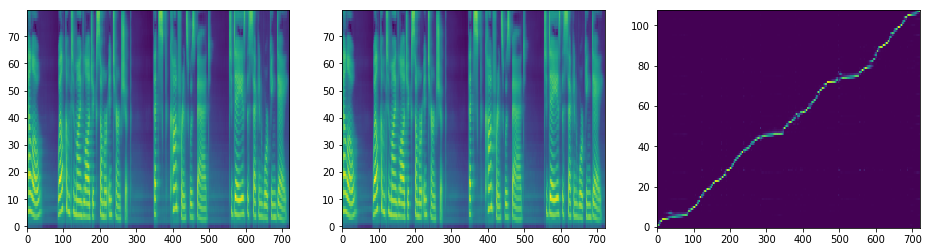

In [0]:
plot_data((mel_outputs.data.cpu().numpy()[0],
           mel_outputs_postnet.data.cpu().numpy()[0],
           alignments.data.cpu().numpy()[0].T))

### Synthesize audio from Mel spectrogram using WaveGlow¶
it will takes 17 sec on K80. it include redundant memory copy time.

In [0]:
%%time
with torch.no_grad():
    audio = waveglow.infer(mel_outputs_postnet, sigma=0.666)

CPU times: user 560 ms, sys: 580 ms, total: 1.14 s
Wall time: 1.16 s


#### check audio

In [0]:
print(text)
ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)

Hello, welcome to mindlogic summer internship. That SKT conference was bad. Today is the second working day.


## Measure exact inference time

#### reduce batch to simplify code

In [0]:
print(mel_outputs_postnet.size())
print(mel_outputs_postnet[-1, :, :].size())

torch.Size([1, 80, 721])
torch.Size([80, 721])


#### configure waveglow 

### Generate Audio from Mel spectrogram
in general, it will takes 6.6 seconds on COLAB with Tesla K80 ( Kepler Architecture). if you would use Tesla V100 (Volta Architecture) or Tesla T4(Turing Architecture), you could generate audio in real-time. 

In [0]:
%%time

from mel2samp import MAX_WAV_VALUE
sampling_rate=22050
sigma=0.6

mel = mel_outputs_postnet[-1, :, :]
mel = torch.autograd.Variable(mel.cuda())
mel = torch.unsqueeze(mel, 0)
mel = mel.data
start= time.perf_counter()
with torch.no_grad():
    audio2 = MAX_WAV_VALUE*waveglow.infer(mel, sigma=0.6)[0]
duration= time.perf_counter() - start
print("inference time {:.2f}s/it".format(duration))

inference time 1.15s/it
CPU times: user 592 ms, sys: 551 ms, total: 1.14 s
Wall time: 1.15 s



It will take 30 seconds to download 

In [0]:
%%time
audio2=audio2.data.cpu().numpy()

CPU times: user 842 ms, sys: 670 ms, total: 1.51 s
Wall time: 1.53 s


### check audio

In [0]:
print(text)
ipd.Audio(audio2 , rate=sampling_rate)

Hello, welcome to mindlogic summer internship. That SKT conference was bad. Today is the second working day.
